##### The dataset was supplied through kaggle *https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=results.csv*

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# Data cleaning and Preprocessing
# Read the results data
data_result = pd.read_csv("../Task 2/result.csv")

# Read the race status data
data_status = pd.read_csv('status.csv')

# Read the driver data
data_driver = pd.read_csv('drivers.csv')
data_driver['driverName'] = data_driver['forename'] + ' ' + data_driver['surname']
data_driver.drop(columns=['driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url'], inplace=True)

# Read the team data
data_team = pd.read_csv('constructors.csv')
data_team.drop(columns=['constructorRef', 'nationality', 'url'], inplace=True)

# Read the races data
data_races = pd.read_csv('races.csv')

# merge all data
data = (data_result.merge(data_status, how='right', on='statusId')).merge(data_driver, how='inner', on='driverId')
data = (data.merge(data_team, how='right', on='constructorId')).merge(data_races, how='right', on='raceId')

data["positionChange"] = data['positionOrder'] - data['grid']

# Reorder the columns
col_order = ['resultId', 'year', 'driverName', 'constructorName', 'status', 
            'grid', 'positionOrder', 'positionChange', 'points', 'laps']
data = data.reindex(columns=col_order)

In [ ]:
data[:5]

In [ ]:
# Cleaning missing data
# get the number of missing data in every column
missing_values_count = data.isnull().sum() 

# there is only one missing row that most of its data is null
# print(missing_values_count)

# get index of all row with missing data
misiing_data_id = data[data.isnull().any(axis=1)].index

# drop row with missing data
data.drop(misiing_data_id, inplace=True)

data[:3]

In [ ]:
# Top Performers based on points
# Get all the unique driver's name 
drivernames = (data['driverName'].unique())

# Store the points of each driver
driver_points = {}

# Calculate the points of each driver
for driver in drivernames:
    driver_points[driver] = (data.loc[data['driverName'] == driver]['points']).sum()

# Sort the list and get the top 10 performers
top_performers = dict(sorted(driver_points.items(), key=lambda item: item[1], reverse=True)[:10])
top_performers = pd.DataFrame(top_performers.items(), columns=['Performer', 'Points'])

# top_performers.columns
# Plot the data
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=top_performers,
    x='Performer',
    y='Points'
)

# Add a title and labels for clarity
plt.title('Top 10 Performers by Points', fontsize=18, fontweight='bold')
plt.xlabel('Performer Name', fontsize=12)
plt.ylabel('Points', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Set the y-axis to start at 0 for accurate comparison
plt.ylim(0, top_performers['Points'].max() * 1.1)

# Add text annotations on top of each bar to display the exact points
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig("top_performers.png")
plt.show()

In [ ]:
# Top Teams based on points per race
# Get all the unique driver's name 
constructorNames = (data['constructorName'].unique())

# Store the points of each driver
constructor_points = {}

# Calculate the points of each driver
for constructor in constructorNames:
    constructor_points[constructor] = (data.loc[data['constructorName'] == constructor]['points']).sum() / len(data.loc[data['constructorName'] == constructor]['raceId'])

# Sort the list and get the top 10 performers
top_team = dict(sorted(constructor_points.items(), key=lambda item: item[1], reverse=True)[:10])
top_team = pd.DataFrame(top_team.items(), columns=['Constructor', 'Points'])

# Plot the data
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=top_team,
    x='Constructor',
    y='Points'
)

# Add a title and labels for clarity
plt.title('Top 10 Constructor by Points', fontsize=18, fontweight='bold')
plt.xlabel('Constructor Name', fontsize=12)
plt.ylabel('Points', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Set the y-axis to start at 0 for accurate comparison
plt.ylim(0, top_team['Points'].max() * 1.1)

# Add text annotations on top of each bar to display the exact points
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig("top_team.png")
plt.show()

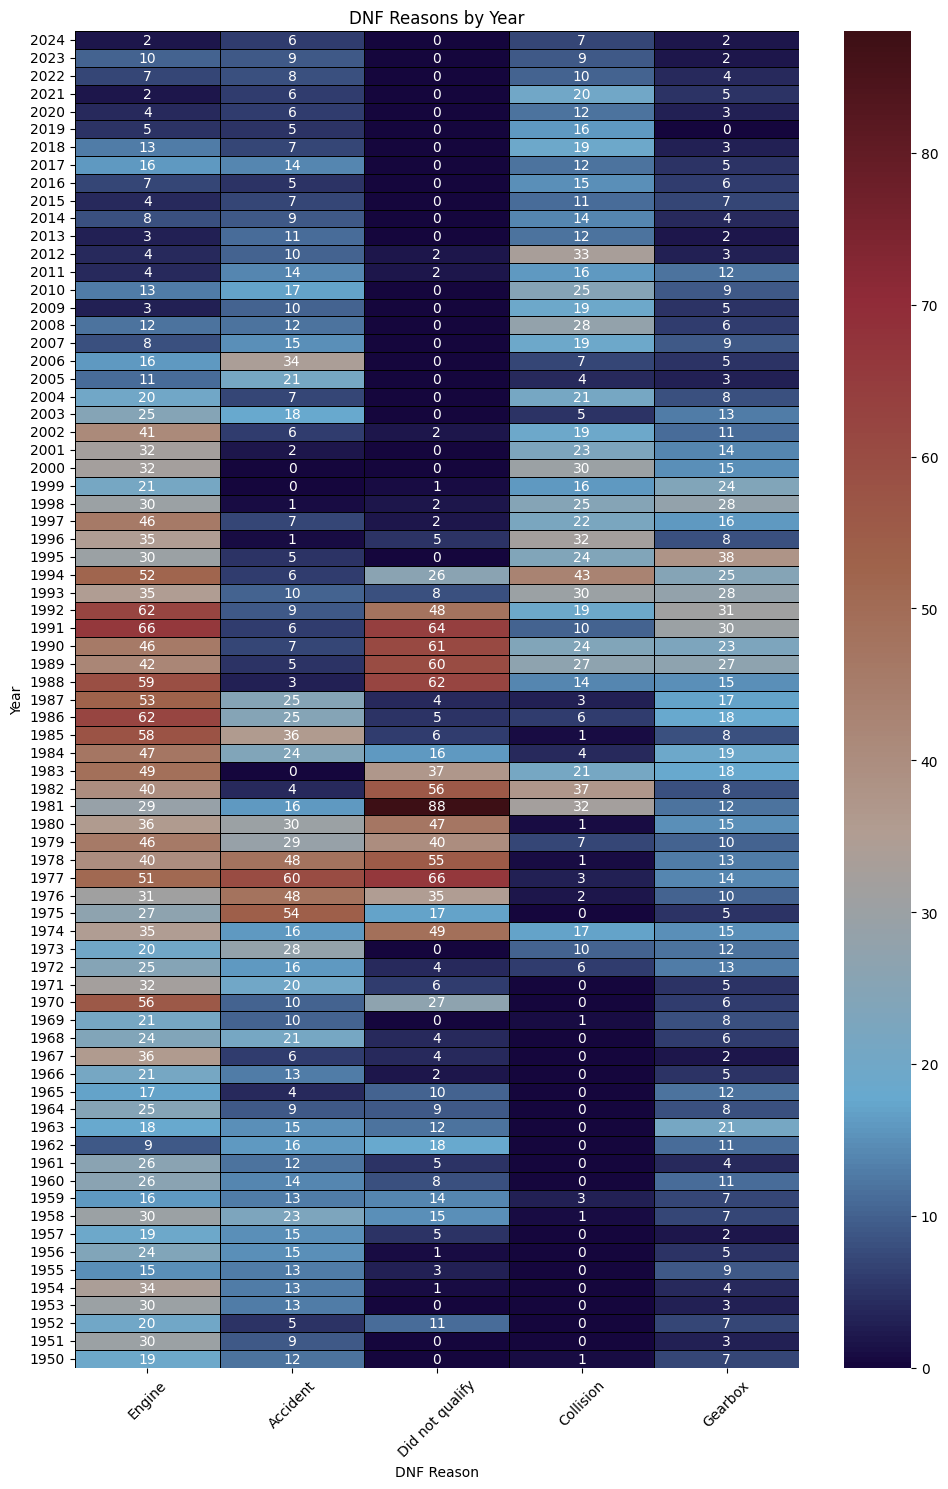

In [ ]:
# Reliability Analysis
# Get the uniques values for each year and cosider it an era
eras = data['year'].unique()

# list of values that show the driver finished the race
finish_list = [
    'Finished', '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps',
    '+6 Laps', '+7 Laps', '+8 Laps', '+9 Laps', '+10 Laps', '+11 Laps',
    '+12 Laps', '+13 Laps', '+14 Laps', '+15 Laps', '+16 Laps', '+17 Laps',
    '+18 Laps', '+19 Laps', '+20 Laps', '+21 Laps', '+22 Laps', '+23 Laps',
    '+24 Laps', '+25 Laps', '+26 Laps', '+29 Laps', '+30 Laps', '+42 Laps', '+44 Laps', '+46 Laps'
]

# pairs of reasons the racer didn't finish and year
dnf_data = {}

# Loop for each year
for year in eras:
    # Filter the DataFrame to get data for the current year
    year_data = data.loc[data['year'] == year]

    # Find the row with values that show the driver didn't finish
    dnf_year_data = year_data.loc[~year_data['status'].isin(finish_list)]

    # Count the occurrences of each unique status and store it as a dictionary
    dnf_data[year] = dnf_year_data['status'].value_counts().to_dict()


# Plotting the data
heatmap_df = pd.DataFrame.from_dict(dnf_data, orient='index').sort_index(ascending=False)

# Set the number of top reasons you want to display
num_top_reasons = 5

# Calculate the total count for each DNF reason and get the top N reasons
top_reasons = heatmap_df.sum().nlargest(num_top_reasons).index.tolist()

# Filter the DataFrame to include only the top reasons
filtered_heatmap_df = heatmap_df[top_reasons].fillna(0)

# Get the number of rows and columns to automatically adjust the plot size
rows, cols = filtered_heatmap_df.shape
fig_width = max(10, cols * .5)  # Base width of 10, but scale up for more columns
fig_height = max(6, rows * 0.2) # Base height of 6, but scale up for more rows

# Custom color mappings
hex_colors_quartiles = ["#15063d", "#67a9cf", "#b19d92", "#9f634b", "#902b38", "#3d0f15"]
positions = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Create a custom colormap with four distinct colors.
# matplotlib will automatically create transitions at equal intervals
# between the colors, effectively creating four quartiles in the color scale.
custom_cmap_quartiles = LinearSegmentedColormap.from_list(
    "custom_quartiles",
    list(zip(positions, hex_colors_quartiles)),
    N=256 # A higher N gives a smoother transition
)

# Create the heatmap with enhanced styling and dynamic figure size
plt.figure(figsize=(fig_width, fig_height))

sns.heatmap(
    filtered_heatmap_df,
    annot=True,              # Display the value in each cell
    cmap=custom_cmap_quartiles,          # Use a different color map for contrast
    linewidths=.5,           # Add lines between cells for better separation
    linecolor='black'        # Set the line color
)

plt.title('DNF Reasons by Year')
plt.xlabel('DNF Reason')
plt.ylabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("reliability_analysis.png")
plt.show()

In [ ]:
# Worest Performers based on points
# Calculate the points of each driver
for driver in drivernames:
    driver_points[driver] = (data.loc[data['driverName'] == driver]['positionChange']).sum() * -1

# Sort the list and get the top 10 performers
worest_performers = dict(sorted(driver_points.items(), key=lambda item: item[1], reverse=True)[:10])
worest_performers = pd.DataFrame(worest_performers.items(), columns=['Performer', 'Positions Lost'])

# top_performers.columns
# Plot the data
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=worest_performers,
    x='Performer',
    y='Positions Lost'
)

# Add a title and labels for clarity
plt.title('Worest 10 Performers by Positions Lost', fontsize=18, fontweight='bold')
plt.xlabel('Performer Name', fontsize=10)
plt.ylabel('Positions Lost', fontsize=10)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Set the y-axis to start at 0 for accurate comparison
plt.ylim(0, worest_performers['Positions Lost'].max() * 1.1)

# Add text annotations on top of each bar to display the exact points
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig("worest_performers.png")
plt.show()

In [ ]:
# 